<img src="DS Practical Header.png"/>

The project aims to compare the performance of a transformer-based recommendation system with multi-head attention against a system using an xLSTM block stack. The xLSTM, introduced in the paper "xLSTM: Extended Long Short-Term Memory," proposes enhancements to the classic LSTM architecture, including exponential gating, new stabilization methods, and a new memory structure for parallelization.

The central research questions are:
1. How do transformer and xLSTM architectures compare in predictive performance in a sequence-based Size & Fit recommendation system?
2. What impact do dataset characteristics and sequence length have on this comparison?
3. How does xLSTM perform in terms of trainable parameters, runtime, and memory usage?

---

# Table of Contents
### [1 Setup](#setup)
### [2 Data Generation](#data_generation)
* [2.1 Global Definitions](#global_definitions)
* [2.2 Consumer Data Generation](#consumer_data)
* [2.3 Product Data Generation](#product_data)
* [2.4 Transaction Data Generation](#transaction_data)
### [3 Data Exploration](#data_exploration)
* [3.1 Consumer Data](#consumer_data_viz)
* [3.2 Product Data](#product_data_viz)
* [3.3 Transaction Data](#transaction_data_viz)
### [4 Model Training](#model_training)
* [4.1 Data Preparation](#data_preparation)
* [4.2 Random Forest - Baseline Model](#random_forest)
* [4.3 Transformer](#transformer)

---

## 1 Setup <a id="setup"></a>

This section includes necessary library imports and the setting of the random seed for reproducibility of the results.

In [7]:
import warnings
warnings.filterwarnings("ignore")

# Data processing
import pandas as pd
import numpy as np
from datetime import timedelta
from scipy.stats import truncnorm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [8]:
# Random seed
np.random.seed(111)

---

## 2 Data Generation <a id="data_generation"></a>

This section includes creating the synthetic data used to train and evaluate the models.

### 2.1 Global Definitions <a id="global_definitions"></a>
Define the gender and country lists used across the dataset generation process.

In [12]:
genders = ['Male', 'Female', 'Other']
countries = ['USA', 'Germany', 'UK', 'Japan']

### 2.2 Consumer Data Generation <a id="consumer_data"></a>

This section creates a DataFrame for consumer features including ID, gender, country, and age, along with their respective clothing and shoe sizes. It also includes personal margins for size tolerance.

In [14]:
# Parameters

# Total number of customers
n_consumers = 1000

# Average age and standard deviation
age_mean = 35
age_std = 10

In [15]:
# Define size distributions by gender (the gender "Other" is simply the average of male and female)

# Universal clothing sizes for simplicity
sizes = ['2XS', 'XS', 'S', 'M', 'L', 'XL', '2XL']
size_dists = {
    'Female': np.array([1, 5, 30, 26, 20, 10, 8]) / 100,
    'Male': np.array([0.5, 1, 7, 28, 30, 20, 13.5]) / 100
}
size_dists['Other'] = (size_dists['Female'] + size_dists['Male']) / 2

# Shoe sizes from 4.5 to 15.5 (UK scale for simplicity)
shoe_sizes = np.arange(4.5, 16, 0.5)

# Shoe sizes frequency extracted from an online resource
frequency_male = np.array([1, 2, 3, 4, 6, 7, 9, 11, 12, 14, 12, 10, 9, 7, 6, 4, 3, 2, 2, 1, 1, 0, 0])
frequency_female = np.array([0, 1, 2, 3, 5, 7, 9, 11, 13, 15, 14, 12, 10, 8, 7, 5, 4, 3, 2, 1, 1, 0, 0])

# Normalize to calculate probabilites
shoe_size_dist = {
    'Female': frequency_female / frequency_female.sum(),
    'Male': frequency_male / frequency_male.sum()
}
shoe_size_dist['Other'] = (shoe_size_dist['Female'] + shoe_size_dist['Male']) / 2

In [16]:
# Function to generate correlated upper and lower sizes based on gender-specific distributions
def assign_sizes(row):
    
    """
    Assigns correlated upper and lower clothing sizes and a shoe size to a consumer.
    
    For clothing sizes, it randomly selects an index using a gender-specific probability distribution.
    For shoe sizes, it uses the gender-specific frequency distribution combined with a Gaussian 
    centered around a mean shoe size derived from the clothing size index.
    
    Parameters:
    - row: DataFrame row containing consumer data.
    
    Returns:
    - Series containing upper_size, lower_size, and shoe_size.
    """

    # Assign upper clothing parts size
    upper_size_idx = np.random.choice(range(len(sizes)), p = size_dists[row['gender']])
    
    # Assign lower clothing part size by applying a simple correlation factor: mostly the same size, sometimes one size apart
    if np.random.rand() < 0.80:
        lower_size_idx = upper_size_idx
    else:
        lower_size_idx = np.random.choice([max(0, upper_size_idx - 1), min(len(sizes) - 1, upper_size_idx + 1)])

    # Assign shoe size
    shoe_choice = np.random.choice(shoe_sizes, p = shoe_size_dist[row['gender']])

    # Get the base frequency distribution for shoe sizes based on gender.
    if row['gender'] == 'Female':
        base_freq = frequency_female
    elif row['gender'] == 'Male':
        base_freq = frequency_male
    else:
        base_freq = (frequency_female + frequency_male) / 2.0

    # Normalize the frequency distribution to form probabilities.
    base_prob = base_freq / base_freq.sum()
    
    # Map the clothing size index (upper_size_idx) to a base mean shoe size using linear interpolation.
    # The mapping is from the clothing size range (indices 0 to len(sizes)-1) to the shoe size range.
    min_shoe = shoe_sizes[0]
    max_shoe = shoe_sizes[-1]
    base_mean_shoe = min_shoe + (max_shoe - min_shoe) * (upper_size_idx / (len(sizes) - 1))
    
    # Apply a gender-specific offset to adjust the mean shoe size:
    # For females, subtract 0.5; for males, no offset; for "Other", use an intermediate offset.
    if row['gender'] == 'Female':
        gender_offset = -0.5
    elif row['gender'] == 'Male':
        gender_offset = 0.0
    else:
        gender_offset = -0.25
    mean_shoe = base_mean_shoe + gender_offset
    
    # Define a Gaussian (normal) distribution over the shoe sizes centered at mean_shoe.
    # A small sigma (e.g., 0.5) ensures the distribution is peaked around the mean.
    sigma = 0.5
    gaussian_weights = np.exp(-0.5 * ((shoe_sizes - mean_shoe) / sigma)**2)
    gaussian_weights = gaussian_weights / gaussian_weights.sum()  # Normalize to sum to 1
    
    # Combine the base frequency probabilities with the Gaussian weights.
    # This product emphasizes shoe sizes near the mean while retaining the overall frequency distribution.
    combined_prob = base_prob * gaussian_weights
    combined_prob = combined_prob / combined_prob.sum()  # Renormalize to sum to 1
    
    # Sample a shoe size from the combined probability distribution.
    shoe_choice = np.random.choice(shoe_sizes, p=combined_prob)

    return pd.Series([sizes[upper_size_idx], sizes[lower_size_idx], shoe_choice])

In [17]:
def assign_personal_margins(consumer_df):
    
    """
    Generates personal size tolerance margins for consumers, adjusted by gender and country.
    
    Parameters:
    - consumer_df: DataFrame containing consumer data with 'gender' and 'country' columns.
    
    Returns:
    - Two pandas Series representing the tolerance margins for products that run too small and too large.
    """
    
    n = len(consumer_df)
    
    # Baseline margins (sampled uniformly)
    baseline_small = np.random.uniform(-0.5, 0, size = n)   # Baseline tolerance for "too small"
    baseline_large = np.random.uniform(0, 0.65, size = n)     # Baseline tolerance for "too large"
    
    # Define gender-based adjustments for margins
    gender_adj_small = {'Male': -0.1, 'Female': 0.1, 'Other': 0.0}
    gender_adj_large = {'Male': 0.1, 'Female': -0.1, 'Other': 0.0}
    
    # Define country-based adjustments for margins
    country_adj_small = {'USA': -0.1, 'Germany': 0.0, 'UK': 0.1, 'Japan': -0.05}
    country_adj_large = {'USA': 0.1, 'Germany': 0.0, 'UK': -0.1, 'Japan': 0.05}
    
    margins_small = []
    margins_large = []
    
    # Loop over each consumer and adjust the baseline margins using gender and country
    for i, row in consumer_df.iterrows():
        
        g = row['gender']
        c = row['country']
        
        # Adjust baseline with gender and country corrections
        margin_small = baseline_small[i] + gender_adj_small.get(g, 0) + country_adj_small.get(c, 0)
        margin_large = baseline_large[i] + gender_adj_large.get(g, 0) + country_adj_large.get(c, 0)
        
        margins_small.append(round(margin_small, 2))
        margins_large.append(round(margin_large, 2))
    
    return pd.Series(margins_small), pd.Series(margins_large)

In [18]:
# Generate consumer features
consumer_features = pd.DataFrame({
    'consumer_id': [f'c_{i}' for i in range(1, n_consumers + 1)],
    'gender': np.random.choice(genders, size = n_consumers, p = [0.4, 0.45, 0.15]),
    'country': np.random.choice(countries, size = n_consumers),
    'age': np.clip(np.random.normal(age_mean, age_std, size = n_consumers), 18, 65).astype(int)
})

In [19]:
# Assign sizes
consumer_features[['upper_size', 'lower_size', 'shoe_size']] = consumer_features.apply(assign_sizes, axis = 1)

In [20]:
# Add personal margins to consumers
consumer_features['consumer_tolerance_too_small'], consumer_features['consumer_tolerance_too_large'] = assign_personal_margins(consumer_features)

In [21]:
# Add date of first purchase
consumer_features['start_date'] = pd.to_datetime('2021-01-01') + pd.to_timedelta(np.random.randint(0, 365, size = len(consumer_features)), unit = 'd')

In [22]:
consumer_features.sample(10)

,consumer_id,gender,country,age,upper_size,lower_size,shoe_size,consumer_tolerance_too_small,consumer_tolerance_too_large,start_date
206,c_207,Female,UK,25,S,XS,8.0,0.14,0.05,2021-03-28
327,c_328,Female,UK,53,M,S,9.5,-0.01,-0.05,2021-05-24
839,c_840,Female,UK,31,2XL,2XL,14.5,0.04,0.20,2021-07-30
300,c_301,Male,USA,36,L,L,11.5,-0.43,0.38,2021-04-13
306,c_307,Male,Japan,45,L,L,12.0,-0.25,0.24,2021-02-17
630,c_631,Male,UK,46,L,L,11.0,-0.42,0.21,2021-06-10
674,c_675,Other,Japan,43,2XL,2XL,14.5,-0.18,0.46,2021-06-12
290,c_291,Female,USA,48,M,M,9.5,-0.48,0.54,2021-08-05
625,c_626,Female,USA,30,S,S,8.0,-0.19,0.60,2021-08-21
363,c_364,Male,USA,36,XL,XL,13.0,-0.44,0.78,2021-11-24


### 2.3 Product Data Generation <a id="product_data"></a>
This section creates a DataFrame for consumer features including product type, material, and sizing characteristics which influence the fit of the product. It also includes information on the country and section (gender orientation) the products are intended for.

In [24]:
# Parameters

# Total number of unique articles
n_articles = 1000  

In [25]:
# Define product types and associated materials
product_types = ['T-Shirts & Tops', 'Sweatshirts/Hoodies', 'Sportswear', 'Pants & Leggings', 'Jackets', 'Shoes']
materials_by_type = {
    'T-Shirts & Tops': (['Cotton', 'Recycled Polyester', 'Polyester'], [0.5, 0.3, 0.2]),
    'Sweatshirts/Hoodies': (['Cotton', 'Recycled Polyester', 'Polyester'], [0.6, 0.3, 0.1]),
    'Sportswear': (['Aeroready Technology', 'Recycled Polyester', 'Spandex'], [0.5, 0.3, 0.2]),
    'Pants & Leggings': (['Polyester', 'Spandex', 'Recycled Polyester', 'Nylon'], [0.5, 0.2, 0.2, 0.1]),
    'Jackets': (['Polyester', 'Recycled Polyester', 'Nylon', 'Primeknit'], [0.5, 0.3, 0.1, 0.1]),
    'Shoes': (['Primeknit', 'Recycled Polyester', 'Parley Ocean Plastic'], [0.5, 0.3, 0.2])
}

In [26]:
# Define fit types and sizing accuracy
fit_types = ['slim', 'regular', 'loose']
size_accuracy = ['runs small', 'true to size', 'runs large']

In [27]:
def assign_countries():

    """
    Assigns each article to 1-3 randomly selected countries where it is available.

    Returns:
    - A list of randomly selected country names from the predefined 'countries' list.
    """
    
    # Select the number of countries for an article
    num_countries = np.random.choice([1, 2, 3], p = [0.5, 0.3, 0.2])
    
    # Select random countries
    available_countries = list(np.random.choice(countries, size = num_countries, replace = False))
    
    return available_countries

In [28]:
def select_material(product_type):

    """
    Selects a material for a given product type based on predefined probabilities.
    
    Parameters:
    - product_type: Type of the product for which material needs to be selected.
    
    Returns:
    - A selected material as a string.
    """

    # Extract materials and probabilities for the specific product type
    materials, probs = materials_by_type[product_type]
    
    # Select a random material
    selected_material = np.random.choice(materials, p = probs)
    
    return selected_material

In [29]:
# Function to assign a variable fit offset based on both fit type and size accuracy
def assign_fit_offset(row):

    """
    Assigns a fit offset to a product based on its fit type, size accuracy, material, country and gender.
    
    Parameters:
    - row: DataFrame row containing product information.
    
    Returns:
    - A numerical fit offset that affects how the product fits.
    """
    
    # Define adjustments by fit type with random variability
    fit_type_offsets = {
        'slim': np.random.uniform(-0.6, -0.4),  # Slim fits tend to be tighter
        'regular': np.random.uniform(-0.2, 0.2),  # Regular fits are around standard
        'loose': np.random.uniform(0.4, 0.6)   # Loose fits offer more room
    }
    fit_offset = fit_type_offsets[row['fit_type']]

    # Define adjustments by size accuracy with random variability
    size_accuracy_offsets = {
        'runs small': np.random.uniform(-0.6, -0.4),  # Size smaller than expected
        'true to size': np.random.uniform(-0.2, 0.2),   # Size as expected
        'runs large': np.random.uniform(0.4, 0.6)    # Size larger than expected
    }
    acccuracy_offset = size_accuracy_offsets[row['size_accuracy']]

    # Define material influence on fit
    material_fit_influence = {
        'Cotton': -0.1,
        'Recycled Polyester': -0.05,
        'Polyester': 0,
        'Spandex': 0.2,
        'Aeroready Technology': 0.1,
        'Nylon': 0.15,
        'Primeknit': 0.2,
        'Parley Ocean Plastic': 0.1
    }
    material_influence = material_fit_influence.get(row['material'], 0)

    # Define gender adjustment
    gender_adjustments = {
        "Male": 0.1,  # Slightly larger fit for males
        "Female": -0.1,  # Slightly smaller fit for females
        "Other": 0.0,  # No adjustment for other genders
    }
    section_offset = gender_adjustments[row['section']]

    # Calculate total offset by combining all dimensions
    total_offset = fit_offset + acccuracy_offset + material_influence + section_offset
    
    return round(total_offset, 2)

In [30]:
# Generate article features
article_features = pd.DataFrame({
    'article_id': [f'a_{i}' for i in range(1, n_articles + 1)],
    'section': np.random.choice(genders, size = n_articles),
    'product_type': np.random.choice(product_types, size = n_articles),
    'fit_type': np.random.choice(fit_types, size = n_articles, p =[ 0.3, 0.4, 0.3]),
    'size_accuracy': np.random.choice(size_accuracy, size = n_articles, p = [0.1, 0.8, 0.1])
})

In [31]:
# Assign each article to multiple countries
article_features['available_countries'] = article_features.apply(lambda _: assign_countries(), axis=1)

In [32]:
# Assign material to each product based on its type
article_features['material'] = article_features['product_type'].apply(select_material)

In [33]:
# Update article features with combined fit_offset
article_features['fit_offset'] = article_features.apply(assign_fit_offset, axis = 1)

In [34]:
article_features.sample(10)

,article_id,section,product_type,fit_type,size_accuracy,available_countries,material,fit_offset
976,a_977,Female,T-Shirts & Tops,regular,runs large,[UK],Recycled Polyester,0.15
392,a_393,Male,Sweatshirts/Hoodies,regular,runs large,[Germany],Cotton,0.50
459,a_460,Other,Sportswear,loose,true to size,"[USA, UK]",Aeroready Technology,0.66
246,a_247,Female,T-Shirts & Tops,regular,true to size,[Germany],Cotton,-0.07
797,a_798,Other,Sweatshirts/Hoodies,slim,true to size,"[UK, Japan]",Recycled Polyester,-0.49
853,a_854,Other,T-Shirts & Tops,loose,true to size,[USA],Polyester,0.37
753,a_754,Female,Pants & Leggings,regular,runs large,[Germany],Recycled Polyester,0.54
594,a_595,Male,Sportswear,regular,true to size,"[USA, Germany]",Spandex,0.37
525,a_526,Female,Pants & Leggings,regular,true to size,[USA],Nylon,-0.23
437,a_438,Male,Jackets,slim,true to size,"[USA, Germany, UK]",Nylon,-0.24


### 2.4 Transaction Data Generation <a id="transaction_data"></a>

This section create the transaction DataFrame which simulates consumer purchases. The process involves generating a realistic number of purchases for each consumer, determining the purchase dates to simulate sequential transactions, sampling a purchased size based on consumer preferences, and calculating the fit outcome based on the product and consumer characteristics.

In [36]:
def generate_purchases(max_purchases = 3000):
    
    """
    Generates a realistic number of purchases for a consumer based on a truncated normal distribution.
    
    Parameters:
    - max_purchases: The maximum number of purchases allowed.
    
    Returns:
    - An integer representing the number of purchases.
    """
    
    mean = 5
    std_dev = 2.0
    lower, upper = 1, max_purchases
    a, b = (lower - mean) / std_dev, (upper - mean) / std_dev
    base_sample = truncnorm(a, b, loc = mean, scale = std_dev).rvs()
    purchases = int(round(base_sample))
    
    # Ensure the number is within the valid range
    purchases = max(lower, min(purchases, upper))

    # Adjust purchase number occasionally
    if purchases != 1 and np.random.rand() < 0.1:
        purchases = 1
        
    return purchases

In [37]:
def generate_sequential_purchases(start_date, num_purchases):

    """
    Generates sequential purchase dates for a given number of purchases starting from a specified date.
    
    Parameters:
    - start_date: The date of the first purchase.
    - num_purchases: The total number of purchases to generate dates for.
    
    Returns:
    - A list of datetime objects representing the dates of each purchase.
    """
    
    purchase_dates = []
    
    for _ in range(num_purchases):
        
        # Days between purchases
        days_between_purchases = np.random.randint(1, 90)  # Randomized days between purchases
        
        # Calculate purchase date
        purchase_date = start_date + timedelta(days = days_between_purchases)
        purchase_dates.append(purchase_date)
        
        # Update start date for the next purchase
        start_date = purchase_date
        
    return purchase_dates

In [38]:
def sample_purchased_size(consumer, product_type):
    
    """
    Samples a purchased size around the consumer's true size with a realistic distribution based on the product type.
    
    Parameters:
    - consumer: The consumer data row.
    - product_type: The type of product being purchased.
    
    Returns:
    - A string or number representing the purchased size.
    """
    
    # Determine the size type to use based on the product type
    if 'Shoes' in product_type:
        size_list = shoe_sizes
        true_size = consumer['shoe_size']
    elif 'Pants & Leggings' in product_type:
        size_list = sizes
        true_size = consumer['lower_size']
    else:
        size_list = sizes
        true_size = consumer['upper_size']
    
    # Get the current index of the true size within the size list
    current_index = np.where(np.array(size_list) == true_size)[0][0]
    
    # Choose a size variation
    size_variation = np.random.choice([-1, 0, 1], p = [0.15, 0.7, 0.15])  # Mostly buys true size, sometimes one size off
    
    # Calculate the new index
    new_index = current_index + size_variation
    
    # Make sure the size is within a valid range
    if new_index > (len(size_list) - 1):
        return size_list[len(size_list) - 1]
    elif new_index < 0:
        return size_list[0]
    else:
        return size_list[new_index]

In [39]:
# Function to simulate a transaction and calculate fit outcome
def calculate_fit(consumer, product_type, purchased_size):
    
    """
    Calculates the fit outcome based on consumer tolerance and article fit offset.
    
    Parameters:
    - consumer: The consumer data row.
    - product_type: The type of product being evaluated.
    - purchased_size: The size that was purchased by the consumer.
    
    Returns:
    - A string indicating the fit outcome ('too small', 'too large', 'fit', 'not applicable').
    """

    size_mapping = {'2XS': 1, 'XS': 2, 'S': 3, 'M': 4, 'L': 5, 'XL': 6, '2XL': 7}
    
    # Determine the size type to use based on the product type
    if 'Shoes' in product_type:
        true_size = consumer['shoe_size']
    elif 'Pants & Leggings' in product_type:
        size_list = size_mapping
        true_size = size_mapping[consumer['lower_size']]
    else:
        size_list = size_mapping
        true_size = size_mapping[consumer['upper_size']]

    # Convert purchased size to numerical value if it's a string
    if isinstance(purchased_size, str):
        purchased_size = size_mapping[purchased_size]

    # Fit offset and tolerances as numerical adjustments
    tolerance_too_small = consumer['consumer_tolerance_too_small']
    tolerance_too_large = consumer['consumer_tolerance_too_large']
    fit_offset = article['fit_offset']
    
    # Calculate the adjusted true size with the fit offset
    adjusted_size = true_size + fit_offset

    # Determine fit outcome based on numerical comparisons
    if purchased_size < adjusted_size + tolerance_too_small:
        return "too small"
    elif purchased_size > adjusted_size + tolerance_too_large:
        return "too large"
    elif (true_size +  tolerance_too_large > purchased_size + fit_offset) & (true_size + tolerance_too_small < purchased_size + fit_offset):
        return "fit"
    return "not applicable"

In [40]:
# Generate transactions
transactions = []
for idx, consumer in consumer_features.iterrows():

    # Get the customer's number of purchases and their dates
    num_purchases = generate_purchases()
    purchase_dates = generate_sequential_purchases(consumer['start_date'], num_purchases)

    # Iterate through the purchases
    for purchase_date in purchase_dates:

        # Filter articles available in the consumer's country
        available_articles = article_features[article_features['available_countries'].apply(lambda x: consumer['country'] in x)]
        
        # Randomly select an article
        article = available_articles.sample(1).iloc[0]
        product_type = article['product_type']

        # Get the pourchased size and fit outcome
        purchased_size = sample_purchased_size(consumer, product_type)
        fit_outcome = calculate_fit(consumer, product_type, purchased_size)
        
        transactions.append({
            'consumer_id': consumer['consumer_id'],
            'article_id': article['article_id'],
            'purchased_size': purchased_size,
            'fit_outcome': fit_outcome,
            'transaction_date': purchase_date
        })

# Create DataFrame from transactions
transaction_df = pd.DataFrame(transactions)

In [41]:
transaction_df.sample(10)

,consumer_id,article_id,purchased_size,fit_outcome,transaction_date
1771,c_380,a_239,L,too small,2022-01-24
1921,c_411,a_623,S,fit,2022-11-17
1474,c_314,a_131,2XL,too small,2022-05-13
4066,c_873,a_581,M,not applicable,2022-10-03
792,c_170,a_701,S,too small,2022-07-29
1419,c_305,a_645,M,too small,2021-10-22
3901,c_841,a_921,L,not applicable,2021-08-20
675,c_145,a_111,M,not applicable,2022-02-14
22,c_6,a_309,XL,too large,2021-04-06
3983,c_858,a_257,S,not applicable,2021-12-12


***

## 3 Data Exploration <a id="data_exploration"></a>

This section includes visualizations to explore and better understand the data.

### 3.1 Consumer Data <a id="consumer_data_viz"></a>

#### Descriptive Statistics

In [46]:
consumer_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   consumer_id                   1000 non-null   object        
 1   gender                        1000 non-null   object        
 2   country                       1000 non-null   object        
 3   age                           1000 non-null   int64         
 4   upper_size                    1000 non-null   object        
 5   lower_size                    1000 non-null   object        
 6   shoe_size                     1000 non-null   float64       
 7   consumer_tolerance_too_small  1000 non-null   float64       
 8   consumer_tolerance_too_large  1000 non-null   float64       
 9   start_date                    1000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 78.3+ KB


In [47]:
consumer_features.describe()

,age,shoe_size,consumer_tolerance_too_small,consumer_tolerance_too_large,start_date
count,1000.000000,1000.000000,1000.000000,1000.000000,1000
mean,34.966000,10.621500,-0.258720,0.330660,2021-07-05 04:58:04.800000
min,18.000000,4.500000,-0.700000,-0.200000,2021-01-01 00:00:00
25%,28.000000,9.000000,-0.390000,0.150000,2021-04-08 18:00:00
50%,35.000000,10.500000,-0.250000,0.330000,2021-07-07 12:00:00
75%,41.000000,12.500000,-0.120000,0.510000,2021-09-30 00:00:00
max,65.000000,14.500000,0.200000,0.850000,2021-12-31 00:00:00
std,9.578026,2.379843,0.189821,0.233638,NaN


In [48]:
consumer_features.head()

,consumer_id,gender,country,age,upper_size,lower_size,shoe_size,consumer_tolerance_too_small,consumer_tolerance_too_large,start_date
0,c_1,Female,UK,43,XS,XS,6.5,-0.20,0.21,2021-01-07
1,c_2,Male,USA,41,L,XL,12.0,-0.38,0.79,2021-03-19
2,c_3,Female,Germany,39,S,XS,7.5,-0.05,0.51,2021-10-12
3,c_4,Female,Japan,43,2XL,2XL,14.5,-0.07,0.13,2021-05-15
4,c_5,Male,USA,39,M,M,9.5,-0.61,0.55,2021-11-10


#### Demographic Distribution

<Axes: xlabel='gender'>

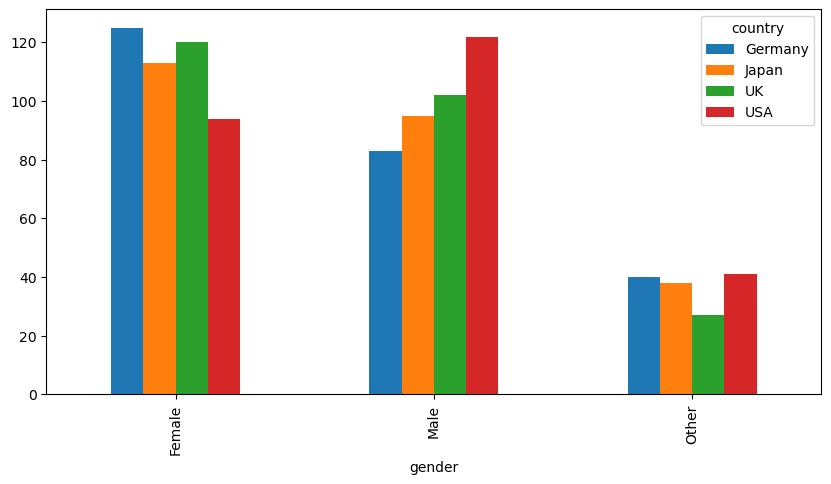

In [50]:
consumer_features[['gender', 'country']].value_counts().unstack().plot(kind = 'bar', figsize = (10,5))

#### Age Distribution

<Axes: xlabel='age', ylabel='Count'>

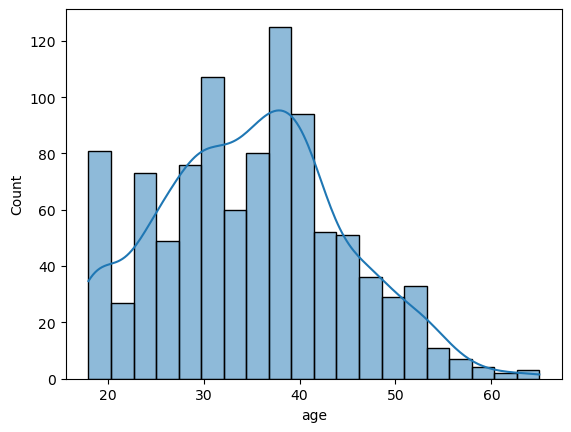

In [52]:
sns.histplot(consumer_features['age'], bins = 20, kde = True)

#### Size Tolerance Distribution by Gender

<Axes: xlabel='gender', ylabel='consumer_tolerance_too_small'>

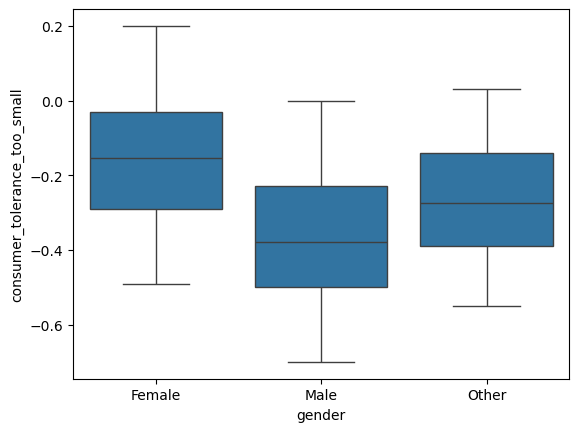

In [54]:
sns.boxplot(data = consumer_features, x = 'gender', y = 'consumer_tolerance_too_small')

<Axes: xlabel='gender', ylabel='consumer_tolerance_too_large'>

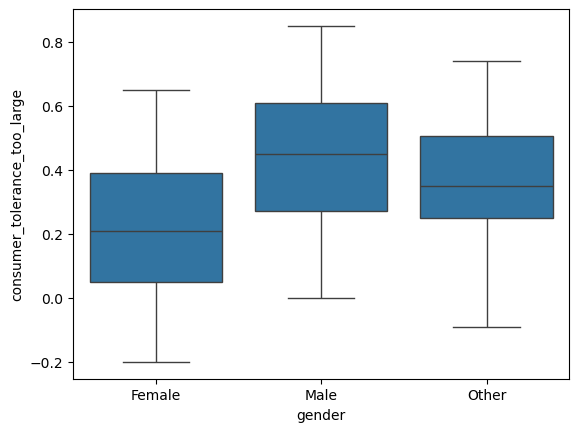

In [55]:
sns.boxplot(data = consumer_features, x = 'gender', y = 'consumer_tolerance_too_large')

### 3.2 Product Data <a id="product_data_viz"></a>

#### Descriptive Statistics

In [58]:
article_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   article_id           1000 non-null   object 
 1   section              1000 non-null   object 
 2   product_type         1000 non-null   object 
 3   fit_type             1000 non-null   object 
 4   size_accuracy        1000 non-null   object 
 5   available_countries  1000 non-null   object 
 6   material             1000 non-null   object 
 7   fit_offset           1000 non-null   float64
dtypes: float64(1), object(7)
memory usage: 62.6+ KB


In [59]:
article_features.describe()

,fit_offset
count,1000.000000
mean,0.001820
std,0.498666
min,-1.190000
25%,-0.390000
50%,-0.020000
75%,0.382500
max,1.350000


In [60]:
article_features.head()

,article_id,section,product_type,fit_type,size_accuracy,available_countries,material,fit_offset
0,a_1,Male,T-Shirts & Tops,regular,runs large,"[UK, USA]",Cotton,0.43
1,a_2,Other,Jackets,regular,true to size,[Germany],Recycled Polyester,-0.14
2,a_3,Other,Jackets,regular,true to size,[Germany],Polyester,0.22
3,a_4,Male,Pants & Leggings,regular,true to size,"[Japan, UK, Germany]",Polyester,0.11
4,a_5,Female,Shoes,loose,true to size,"[Germany, Japan]",Primeknit,0.83


#### Product Type Distribution

<Axes: xlabel='count', ylabel='product_type'>

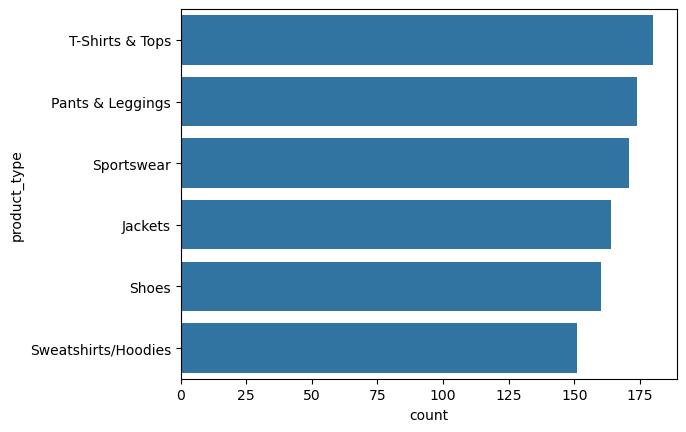

In [62]:
sns.countplot(data = article_features, y = 'product_type', order = article_features['product_type'].value_counts().index)

#### Fit Offset Distribution

<Axes: xlabel='fit_offset', ylabel='Count'>

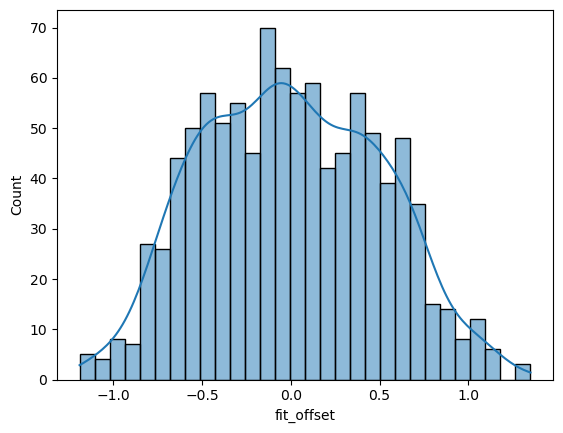

In [64]:
sns.histplot(article_features['fit_offset'], bins = 30, kde = True)

#### Fit Type vs. Size Accuracy

<Axes: xlabel='fit_type'>

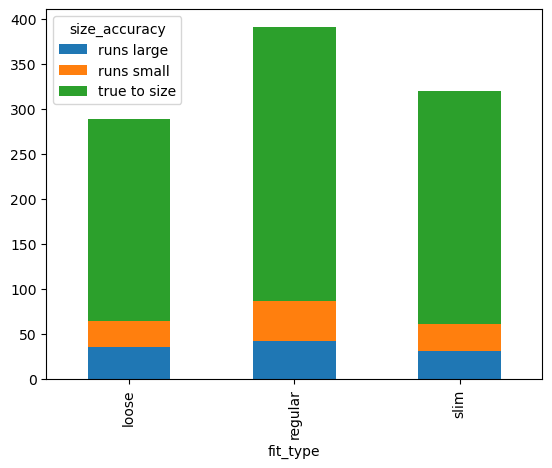

In [66]:
pd.crosstab(article_features['fit_type'], article_features['size_accuracy']).plot(kind = 'bar', stacked = True)

### 3.3 Transaction Data <a id="transaction_data_viz"></a>

#### Descriptive Statistics

In [69]:
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4651 entries, 0 to 4650
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   consumer_id       4651 non-null   object        
 1   article_id        4651 non-null   object        
 2   purchased_size    4651 non-null   object        
 3   fit_outcome       4651 non-null   object        
 4   transaction_date  4651 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 181.8+ KB


In [70]:
transaction_df.describe()

,transaction_date
count,4651
mean,2021-12-05 04:21:37.269404416
min,2021-01-07 00:00:00
25%,2021-08-20 00:00:00
50%,2021-12-04 00:00:00
75%,2022-03-11 12:00:00
max,2023-06-09 00:00:00


In [71]:
transaction_df.head()

,consumer_id,article_id,purchased_size,fit_outcome,transaction_date
0,c_1,a_320,XS,too small,2021-03-23
1,c_1,a_486,S,too large,2021-03-28
2,c_1,a_682,6.0,too small,2021-04-09
3,c_2,a_632,11.5,not applicable,2021-05-15
4,c_2,a_164,XL,not applicable,2021-06-06


#### Fit Outcome Distribution

<Axes: xlabel='fit_outcome', ylabel='count'>

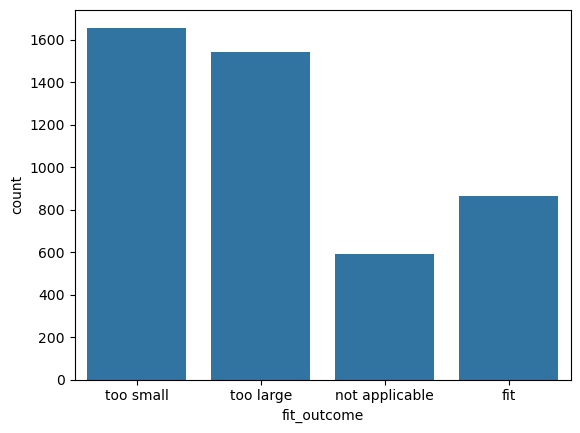

In [73]:
sns.countplot(data = transaction_df, x = 'fit_outcome')

#### Sequence Length Distribution

In [75]:
consumer_purchase_counts = transaction_df['consumer_id'].value_counts()

In [76]:
consumer_purchase_counts.describe()

count    1000.000000
mean        4.651000
std         2.180815
min         1.000000
25%         3.000000
50%         5.000000
75%         6.000000
max        10.000000
Name: count, dtype: float64

The majority of consumers have around 5 transactions.

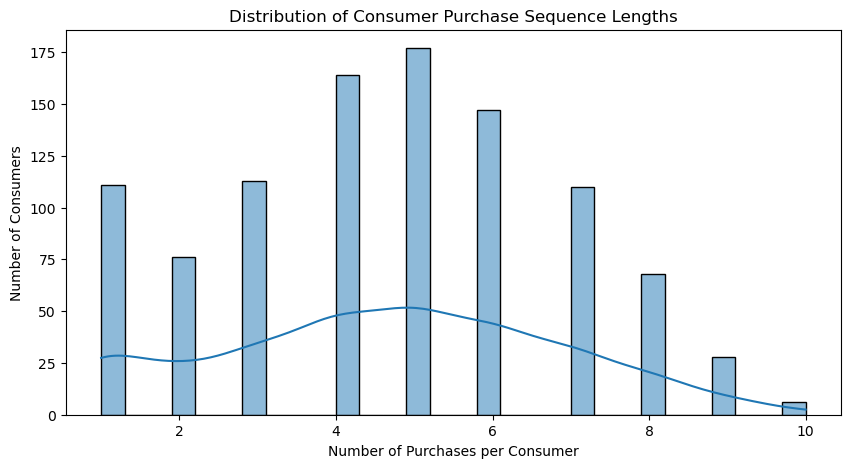

In [78]:
# Plot distribution of sequence lengths
plt.figure(figsize = (10, 5))
sns.histplot(consumer_purchase_counts, bins = 30, kde = True)
plt.xlabel("Number of Purchases per Consumer")
plt.ylabel("Number of Consumers")
plt.title("Distribution of Consumer Purchase Sequence Lengths")
plt.show()

#### Correlation Between Sequence Length and Fit Outcome

In [80]:
# Compute how many times each consumer has each fit outcome
fit_outcome_counts = transaction_df.groupby("consumer_id")["fit_outcome"].value_counts().unstack(fill_value=0)

# Add sequence length (total number of purchases per consumer)
fit_outcome_counts["sequence_length"] = transaction_df["consumer_id"].value_counts()

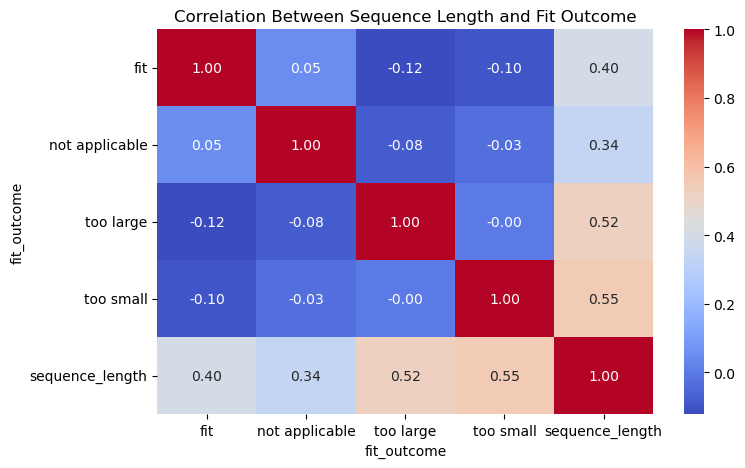

In [81]:
# Compute correlation matrix
correlation_matrix = fit_outcome_counts.corr()

# Display correlation heatmap
plt.figure(figsize = (8, 5))
sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm", fmt = ".2f")
plt.title("Correlation Between Sequence Length and Fit Outcome")
plt.show()

In [82]:
# Summarize trends by grouping consumers into bins based on sequence length
fit_outcome_counts.groupby(pd.cut(fit_outcome_counts["sequence_length"], bins = [0, 2, 5, 8, 12]), observed = True).mean()

fit_outcome,fit,not applicable,too large,too small,sequence_length
sequence_length,,,,,
"(0, 2]",0.294118,0.192513,0.438503,0.481283,1.406417
"(2, 5]",0.711454,0.513216,1.396476,1.519824,4.140969
"(5, 8]",1.252308,0.858462,2.270769,2.375385,6.756923
"(8, 12]",2.264706,1.235294,2.588235,3.088235,9.176471


Consumers with 9+ purchases have nearly 3 "too small" or "too large" fit issues. Consumers with fewer than 3 purchases tend to report fewer fit issues, likely due to fewer overall transactions.

#### Gender-Based Size Distributions

In [85]:
shoe_sizes

array([ 4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5,
       10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. ,
       15.5])

In [86]:
# Ensure purchased_size is treated as a string
transaction_df["purchased_size"] = transaction_df["purchased_size"].astype(str)

# Merge transaction_df with consumer_features to get gender information
merged_df = transaction_df.merge(consumer_features[['consumer_id', 'gender']], on = 'consumer_id', how = 'left')

# Define clothing sizes (categorical) and shoe sizes (numerical)
clothing_sizes = {"2XS", "XS", "S", "M", "L", "XL", "2XL"}
shoes_sizes = set(merged_df["purchased_size"]) - clothing_sizes  # Anything not in clothing_sizes

# Create two separate dataframes
clothing_df = merged_df[merged_df["purchased_size"].isin(clothing_sizes)]

# Convert 'purchased_size' to a categorical variable with the specified order
clothing_df["purchased_size"] = pd.Categorical(clothing_df["purchased_size"],
                                               categories = sizes,
                                               ordered = True)

shoe_df = merged_df[merged_df["purchased_size"].isin(shoes_sizes)]

# Convert the shoe sizes to numeric
shoe_df["purchased_size"] = pd.to_numeric(shoe_df["purchased_size"], errors = "coerce")

# Determine the sorted order of unique shoe sizes
shoe_size_order = sorted(shoe_df["purchased_size"].unique())

# Convert 'purchased_size' to a categorical variable with the sorted order
shoe_df["purchased_size"] = pd.Categorical(shoe_df["purchased_size"],
                                           categories = shoe_size_order,
                                           ordered = True)

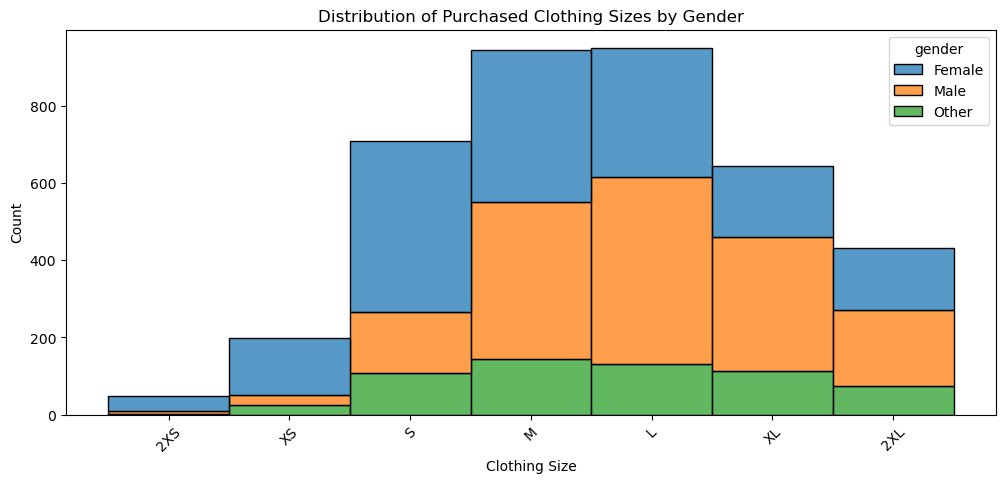

In [87]:
# Plot clothing size distribution by gender
plt.figure(figsize = (12, 5))
sns.histplot(data = clothing_df, x = "purchased_size", hue = "gender", multiple = "stack", discrete = True)
plt.xlabel("Clothing Size")
plt.ylabel("Count")
plt.title("Distribution of Purchased Clothing Sizes by Gender")
plt.xticks(rotation = 45)
plt.show()

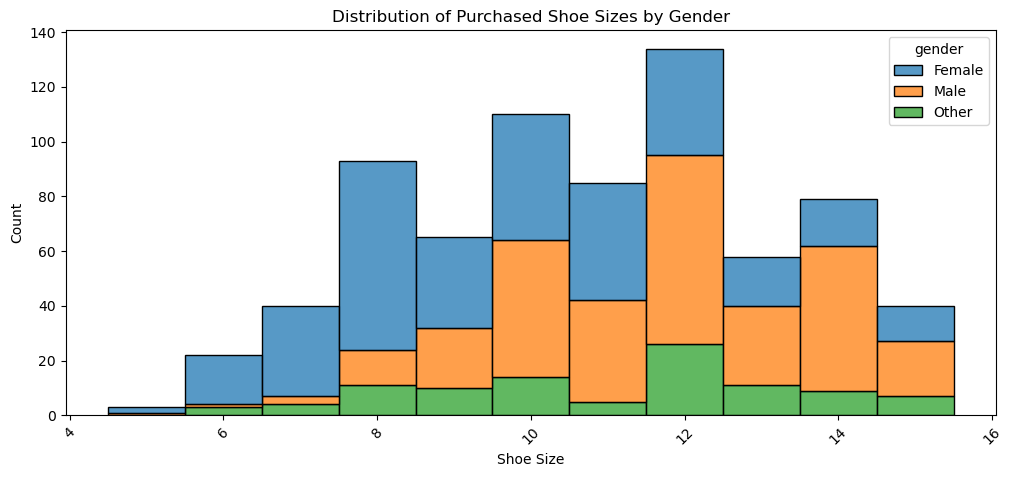

In [88]:
# Plot shoe size distribution by gender
plt.figure(figsize = (12, 5))
sns.histplot(data = shoe_df, x = "purchased_size", hue = "gender", multiple = "stack", bins = shoe_size_order)
plt.xlabel("Shoe Size")
plt.ylabel("Count")
plt.title("Distribution of Purchased Shoe Sizes by Gender")
plt.xticks(rotation = 45)
plt.show()

As expected, females predominantly purchase S and M clothing sizes, while males favor L and XL, with the "Other" category showing a balanced preference for M and L, and 2XS being the least popular size; similarly, females tend to buy smaller shoe sizes (peaking at 7.5, 8.5, and 9.0), males prefer larger sizes (peaking at 9.5, 10.5, and 11.5), and the "Other" category has a more even spread but leans slightly toward smaller sizes, with extreme sizes (4.5, 14.5) being rare

---

## Model Training <a id="model_training"></a>

### Data Preparation <a id="data_preparation"></a>

In [93]:
# Prepare the dataset (merge transactions with consumer and product data)
df = transaction_df.merge(consumer_features, on = 'consumer_id').merge(article_features, on = 'article_id')

In [94]:
# Define features and target variable
X = df[['gender', 'age', 'country', 'product_type', 'section', 'material']]
y = df['fit_outcome']

In [95]:
# Define categorical and numerical features
categorical_features = ['gender', 'country', 'product_type', 'section', 'material']
numerical_features = ['age']

In [96]:
# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('cat', OrdinalEncoder(), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

In [97]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 111)

In [98]:
# Fit and transform training data
X_train = preprocessor.fit_transform(X_train)

# Transform test data using the same scaling parameters
X_test = preprocessor.transform(X_test)

In [99]:
X_train_df = pd.DataFrame(X_train, columns = [categorical_features + numerical_features])
X_train_df.head()

,gender,country,product_type,section,material,age
0,0.0,0.0,2.0,0.0,5.0,-0.517300
1,0.0,0.0,1.0,2.0,6.0,0.000390
2,0.0,1.0,0.0,1.0,4.0,0.414541
3,0.0,3.0,0.0,1.0,4.0,0.518079
4,2.0,3.0,0.0,0.0,5.0,-1.345603


In [100]:
X_test_df = pd.DataFrame(X_test, columns = [categorical_features + numerical_features])
X_test_df.head()

,gender,country,product_type,section,material,age
0,0.0,3.0,2.0,2.0,6.0,-0.724375
1,1.0,1.0,4.0,2.0,6.0,0.311003
2,1.0,0.0,1.0,1.0,4.0,1.139306
3,0.0,0.0,0.0,0.0,2.0,-1.138527
4,1.0,1.0,4.0,0.0,1.0,0.103928


---

### Random Forest - Baseline Model <a id="random_forest"></a>

In [103]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [104]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state = 111)

In [105]:
# Set up Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator = rf_model, 
    param_grid = param_grid, 
    cv = 5,
    scoring = 'accuracy',
    n_jobs = -1
)

In [106]:
# Fit GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=111),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [107]:
# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [108]:
# Train the final Random Forest model with the best parameters
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

In [109]:
# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.4189

Classification Report:
                 precision    recall  f1-score   support

           fit       0.38      0.23      0.29       172
not applicable       0.40      0.07      0.12       118
     too large       0.43      0.47      0.45       309
     too small       0.42      0.59      0.49       332

      accuracy                           0.42       931
     macro avg       0.41      0.34      0.34       931
  weighted avg       0.41      0.42      0.39       931



In [110]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels = ['fit', 'too small', 'too large', 'not applicable'])

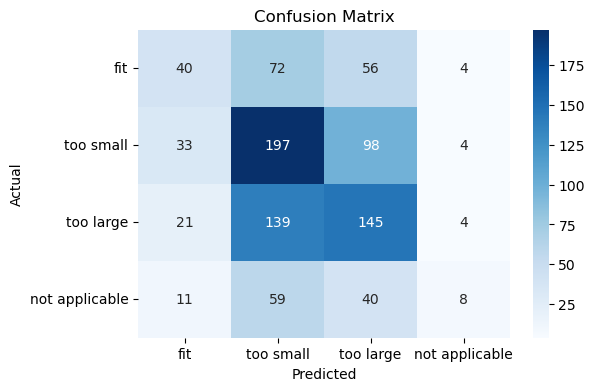

In [111]:
# Plot confusion matrix
plt.figure(figsize = (6, 4))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = ['fit', 'too small', 'too large', 'not applicable'], yticklabels = ['fit', 'too small', 'too large', 'not applicable'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [112]:
# Feature importance
feature_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)) + numerical_features
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': best_rf_model.feature_importances_}).sort_values(by = 'Importance', ascending = False)

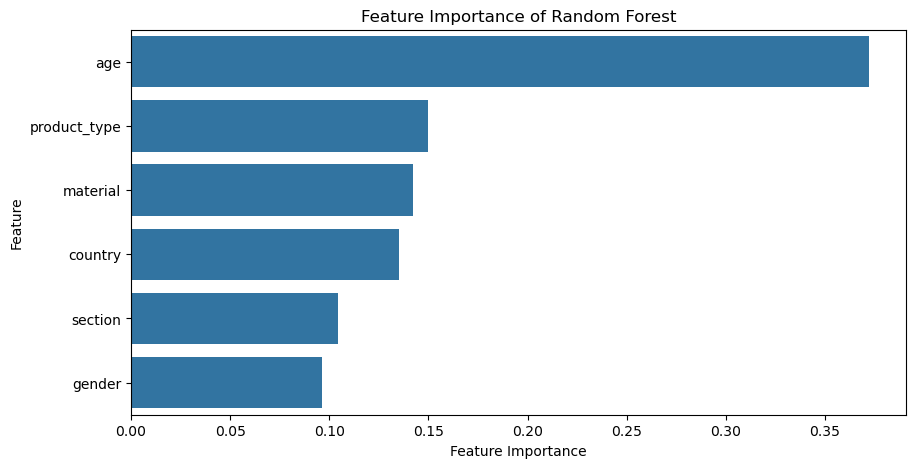

In [113]:
# Plot feature importance
plt.figure(figsize = (10, 5))
sns.barplot(x = 'Importance', y = 'Feature', data = feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of Random Forest')
plt.show()

---

### Transformer <a id="transformer"></a>

In [116]:
TARGET = "fit_outcome"

In [117]:
train_df = X_train_df.copy()
train_df[TARGET] = pd.Series(y_train).reset_index(drop=True)

test_df = X_test_df.copy()
test_df[TARGET] = pd.Series(y_test).reset_index(drop=True)

In [118]:
enc = OrdinalEncoder(dtype=np.int64)
y_train_enc = enc.fit_transform(train_df[[TARGET]]).ravel()
y_test_enc = enc.transform(test_df[[TARGET]]).ravel()

In [119]:
train_df[TARGET] = pd.Series(y_train_enc)
test_df[TARGET] = pd.Series(y_test_enc)

In [120]:
# Columns
USER_CATEGORICALS = ["gender", "country"]
ITEM_CATEGORICALS = ["product_type", "section", "material"]
USER_NUMERICS     = ["age"]
ITEM_NUMERICS     = []

In [121]:
import torch
from torch.utils.data import Dataset, DataLoader

class FrameDataset(Dataset):
    def __init__(self, df, user_cat, item_cat, user_num, item_num, target):
        self.df = df.reset_index(drop=True)
        self.user_cat = user_cat
        self.item_cat = item_cat
        self.user_num = user_num
        self.item_num = item_num
        self.target = target

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        def grab(cols): 
            return [] if not cols else [row[c] for c in cols]
        sample = {
            "user_categoricals": torch.tensor(grab(self.user_cat), dtype=torch.long),
            "item_categoricals": torch.tensor(grab(self.item_cat), dtype=torch.long),
            "user_numeric":      torch.tensor(grab(self.user_num), dtype=torch.float32),
            "item_numeric":      torch.tensor(grab(self.item_num), dtype=torch.float32),
            "fit":               torch.tensor(int(row[self.target]), dtype=torch.long),
        }
        return sample

In [122]:
def collate_batch(batch):
    B = len(batch)
    def stack(key, dtype):
        if len(batch[0][key]) == 0:
            return torch.zeros((B, 0), dtype=dtype)
        return torch.stack([b[key] for b in batch], dim=0).to(dtype)
    return {
        "user_categoricals": stack("user_categoricals", torch.long),
        "item_categoricals": stack("item_categoricals", torch.long),
        "user_numeric":      stack("user_numeric", torch.float32),
        "item_numeric":      stack("item_numeric", torch.float32),
        "fit":               torch.stack([b["fit"] for b in batch], dim=0).to(torch.long),
    }

In [123]:
import torch.nn as nn
import torch.nn.functional as F

In [124]:
def _activation(name: str):
    name = (name or "").lower()
    if name == "relu": return nn.ReLU()
    if name == "gelu": return nn.GELU()
    if name == "silu": return nn.SiLU()
    return nn.ReLU()

In [125]:
def _mlp(in_dim, layers, act, pdrop):
    mods, d = [], in_dim
    for h in layers:
        mods += [nn.Linear(d, h), act, nn.Dropout(pdrop)]
        d = h
    return nn.Sequential(*mods), (d if layers else in_dim)

In [126]:
class SFNetFlexible(nn.Module):
    """
    Two towers (user/item):
      - Embeddings for arbitrary categorical fields
      - Concatenate embeddings + numerics
      - Tower MLPs per side, then combine with u, v, |u-v|, u*v
    """
    def __init__(self, embedding_dim, user_vocab_sizes, item_vocab_sizes,
                 num_user_numeric, num_item_numeric,
                 user_pathway, item_pathway, combined_pathway,
                 dropout, activation, num_targets):
        super().__init__()
        self.embed_dim = embedding_dim
        self.user_embs = nn.ModuleList([nn.Embedding(v, embedding_dim, max_norm=1.0) for v in user_vocab_sizes])
        self.item_embs = nn.ModuleList([nn.Embedding(v, embedding_dim, max_norm=1.0) for v in item_vocab_sizes])

        self.num_user_numeric = num_user_numeric
        self.num_item_numeric = num_item_numeric

        act = _activation(activation)
        pdrop = dropout

        user_in = embedding_dim * len(self.user_embs) + num_user_numeric
        item_in = embedding_dim * len(self.item_embs) + num_item_numeric

        self.user_tower, user_last = _mlp(user_in, user_pathway, act, pdrop)
        self.item_tower, item_last = _mlp(item_in, item_pathway, act, pdrop)
        assert user_last == item_last, "Last dims of user_pathway and item_pathway must match."

        combo_in = user_last * 4  # u, v, |u-v|, u*v
        self.comb_tower, comb_last = _mlp(combo_in, combined_pathway, act, pdrop)
        self.out = nn.Linear(comb_last, num_targets)

    def forward(self, batch):
        # user tower
        if len(self.user_embs):
            u_embs = [emb(batch["user_categoricals"][:, i]) for i, emb in enumerate(self.user_embs)]
            u_cat = torch.cat(u_embs, dim=-1)
        else:
            u_cat = batch["user_numeric"].new_zeros((batch["user_numeric"].size(0), 0))
        u = torch.cat([u_cat, batch["user_numeric"]], dim=-1) if self.num_user_numeric or len(self.user_embs) else batch["user_numeric"]
        u = self.user_tower(u)

        # item tower
        if len(self.item_embs):
            i_embs = [emb(batch["item_categoricals"][:, i]) for i, emb in enumerate(self.item_embs)]
            i_cat = torch.cat(i_embs, dim=-1)
        else:
            i_cat = batch["item_numeric"].new_zeros((batch["item_numeric"].size(0), 0))
        v = torch.cat([i_cat, batch["item_numeric"]], dim=-1) if self.num_item_numeric or len(self.item_embs) else batch["item_numeric"]
        v = self.item_tower(v)

        cross = torch.cat([u, v, torch.abs(u - v), u * v], dim=-1)
        logits = self.out(self.comb_tower(cross))
        return logits


In [127]:
valid_df = test_df.copy()

In [128]:
import torch, random, numpy as np
from torch.utils.data import DataLoader

# Repro & device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42); np.random.seed(42); random.seed(42)

# Infer vocab sizes from train_df (assumes non-negative int ids; include your UNK id in the data if you used one)
def vocab_sizes(df, cols):
    return [int(df[c].max()) + 1 for c in cols] if cols else []

user_vocab_sizes = vocab_sizes(train_df, USER_CATEGORICALS)
item_vocab_sizes = vocab_sizes(train_df, ITEM_CATEGORICALS)

# Datasets & loaders
train_ds = FrameDataset(train_df, USER_CATEGORICALS, ITEM_CATEGORICALS, USER_NUMERICS, ITEM_NUMERICS, TARGET)
valid_ds = FrameDataset(valid_df, USER_CATEGORICALS, ITEM_CATEGORICALS, USER_NUMERICS, ITEM_NUMERICS, TARGET)

BATCH_SIZE = 256
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch, num_workers=0)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch, num_workers=0)

In [129]:
# Model config (keep towers' last dims equal)
EMBED_DIM = 32
USER_PATH = [128, 64]
ITEM_PATH = [128, 64]
COMB_PATH = [128, 64]
NUM_TARGETS = int(train_df[TARGET].max() + 1)

model = SFNetFlexible(
    embedding_dim=EMBED_DIM,
    user_vocab_sizes=user_vocab_sizes,
    item_vocab_sizes=item_vocab_sizes,
    num_user_numeric=len(USER_NUMERICS),
    num_item_numeric=len(ITEM_NUMERICS),
    user_pathway=USER_PATH,
    item_pathway=ITEM_PATH,
    combined_pathway=COMB_PATH,
    dropout=0.2,
    activation="relu",
    num_targets=NUM_TARGETS,
).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.0)
criterion = torch.nn.CrossEntropyLoss()

In [130]:
def run_epoch(loader, train: bool):
    model.train(train)
    total_loss, total_correct, total_n = 0.0, 0, 0
    for step, batch in enumerate(loader, 1):
        for k in batch: batch[k] = batch[k].to(device)
        logits = model(batch)
        loss = criterion(logits, batch["fit"])
        if train:
            opt.zero_grad(); loss.backward(); opt.step()
        with torch.no_grad():
            preds = logits.argmax(dim=-1)
            total_correct += (preds == batch["fit"]).sum().item()
            total_loss += loss.item() * batch["fit"].size(0)
            total_n += batch["fit"].size(0)
    return total_loss / max(total_n,1), total_correct / max(total_n,1)

In [131]:
best = 0.0
for epoch in range(1, 11):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(valid_loader, train=False)
    print(f"[{epoch:02d}] train loss {tr_loss:.4f} acc {tr_acc:.4f} | valid loss {va_loss:.4f} acc {va_acc:.4f}")
    if va_acc > best: best = va_acc

[01] train loss 1.3608 acc 0.3172 | valid loss 1.3039 acc 0.3566
[02] train loss 1.3029 acc 0.3632 | valid loss 1.2874 acc 0.3802
[03] train loss 1.2808 acc 0.3809 | valid loss 1.2708 acc 0.4017
[04] train loss 1.2678 acc 0.3876 | valid loss 1.2630 acc 0.3942
[05] train loss 1.2612 acc 0.4024 | valid loss 1.2609 acc 0.3856
[06] train loss 1.2546 acc 0.4097 | valid loss 1.2582 acc 0.4049
[07] train loss 1.2483 acc 0.4172 | valid loss 1.2543 acc 0.4071
[08] train loss 1.2483 acc 0.4121 | valid loss 1.2504 acc 0.4071
[09] train loss 1.2425 acc 0.4196 | valid loss 1.2474 acc 0.4114
[10] train loss 1.2410 acc 0.4280 | valid loss 1.2471 acc 0.4189
